##kNN-based Estimation of Conditional Distributions

In [11]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_classification, load_breast_cancer
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

In [12]:
def knn_density_estimation(data, k=5, epsilon=1e-5):
    nbrs = NearestNeighbors(n_neighbors=k).fit(data)
    distances, _ = nbrs.kneighbors(data)
    volume = np.pi ** (data.shape[1] / 2) / np.math.gamma(data.shape[1] / 2 + 1)
    distances[:, -1] = np.maximum(distances[:, -1], epsilon)
    densities = k / (len(data) * (distances[:, -1] ** data.shape[1]) * volume)


    densities = np.where(np.isinf(densities) | (densities == 0), np.nan, densities)
    return densities

# 条件分布估计函数
def estimate_conditional_distribution(x, z, k=5, epsilon=1e-5):
    x = x.reshape(-1, 1)
    combined = np.hstack((z, x))
    p_z = knn_density_estimation(z, k, epsilon)
    p_zx = knn_density_estimation(combined, k, epsilon)
    p_x_given_z = np.divide(p_zx, p_z, out=np.zeros_like(p_zx), where=(p_z!=0))
    return p_x_given_z


##Joint Distribution under Conditional Independence

In [13]:
def joint_distribution_conditional_independence(x, y, z, k=5, epsilon=1e-5):
    p_x_given_z = estimate_conditional_distribution(x, z, k, epsilon)
    p_y_given_z = estimate_conditional_distribution(y.reshape(-1, 1), z, k, epsilon)
    p_z = knn_density_estimation(z, k, epsilon)
    joint_dist = p_x_given_z * p_y_given_z * p_z

    joint_dist = np.where(np.isnan(joint_dist) | np.isinf(joint_dist), 1, joint_dist)
    return joint_dist

##Neural Estimation of KL Divergence

In [14]:
class KLNet(nn.Module):
    def __init__(self, input_dim):
        super(KLNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.fc(x)

def neural_kl_divergence(x_samples, y_samples, z_samples, num_epochs=1000, lr=1e-3):
    input_dim = x_samples.shape[1] + 1 + z_samples.shape[1]
    model = KLNet(input_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    x_samples = torch.tensor(x_samples, dtype=torch.float32).reshape(-1, 1)
    y_samples = torch.tensor(y_samples, dtype=torch.float32).reshape(-1, 1)
    z_samples = torch.tensor(z_samples, dtype=torch.float32)

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        joint_samples = torch.cat([x_samples, y_samples, z_samples], dim=1)
        marginal_samples = torch.cat([x_samples, torch.zeros_like(y_samples), z_samples], dim=1)

        joint_scores = model(joint_samples)
        marginal_scores = model(marginal_samples)

        loss = -torch.mean(joint_scores) + torch.log(torch.mean(torch.exp(marginal_scores)))

        loss.backward()
        optimizer.step()

    with torch.no_grad():
        joint_scores = model(joint_samples)
        marginal_scores = model(marginal_samples)
        kl_divergence = torch.mean(joint_scores) - torch.log(torch.mean(torch.exp(marginal_scores)))

    return kl_divergence.item()


##Feature Ranking Based on Conditional Mutual Information

In [15]:
def rank_features(X, y, z, k=5, epsilon=1e-5, num_epochs=1000, lr=1e-3):
    feature_importances = []
    for i in range(X.shape[1]):
        x_i = X[:, i].reshape(-1, 1)
        joint_dist = joint_distribution_conditional_independence(x_i, y, z, k, epsilon)
        kl_div = neural_kl_divergence(x_i, y, z, num_epochs, lr)
        cmi = np.log(joint_dist.mean()) - kl_div
        feature_importances.append(cmi)

    feature_ranking = np.argsort(feature_importances)[::-1]
    return feature_ranking, feature_importances


##Known CMI formula

<ipython-input-12-fa366b1f269c>:4: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  volume = np.pi ** (data.shape[1] / 2) / np.math.gamma(data.shape[1] / 2 + 1)
<ipython-input-12-fa366b1f269c>:4: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  volume = np.pi ** (data.shape[1] / 2) / np.math.gamma(data.shape[1] / 2 + 1)
<ipython-input-12-fa366b1f269c>:4: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  volume = np.pi ** (data.shape[1] / 2) / np.math.gamma(data.shape[1] / 2 + 1)
<ipython-input-12-fa366b1f269c>:4: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`

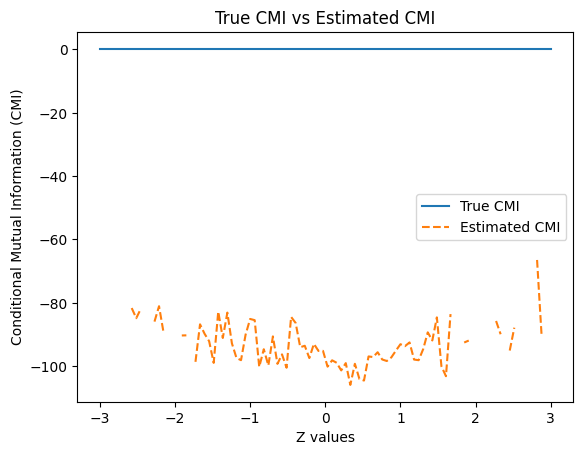

In [16]:
def compute_true_cmi(cov_matrix, mean_vector, z_values):
    mvn = multivariate_normal(mean_vector, cov_matrix)
    cmi_values = []

    for z in z_values:
        # 条件分布的协方差矩阵和均值向量
        cov_xz = cov_matrix[:2, :2]
        cov_xz_cond = cov_matrix[:2, 2] * (1 / cov_matrix[2, 2]) * cov_matrix[2, :2]
        cov_x_given_z = cov_xz - cov_xz_cond
        mean_x_given_z = mean_vector[:2] + cov_matrix[:2, 2] * (z - mean_vector[2])

        # 计算条件互信息
        h_xz = 0.5 * np.log(np.linalg.det(cov_x_given_z))
        h_x = 0.5 * np.log(np.linalg.det(cov_xz))

        cmi = h_x - h_xz
        cmi_values.append(cmi)

    return z_values, cmi_values

# 示例2：估计CMI的示例
def estimate_cmi(cov_matrix, mean_vector, z_values, num_samples=1000, k=5, epsilon=1e-5, num_epochs=1000, lr=1e-3):
    estimated_cmi_values = []

    for z in z_values:
        # 生成数据样本
        data = np.random.multivariate_normal(mean_vector, cov_matrix, size=num_samples)
        X = data[:, 0].reshape(-1, 1)
        Y = data[:, 1].reshape(-1, 1)
        Z = np.full((num_samples, 1), z)

        joint_dist = joint_distribution_conditional_independence(X, Y, Z, k, epsilon)
        kl_div = neural_kl_divergence(X, Y, Z, num_epochs, lr)
        estimated_cmi = np.log(joint_dist.mean()) - kl_div
        estimated_cmi_values.append(estimated_cmi)

    return z_values, estimated_cmi_values

# 示例用法
cov_matrix = np.array([[1, 0.5, 0.3],
                       [0.5, 1, 0.6],
                       [0.3, 0.6, 1]])
mean_vector = np.array([0, 0, 0])
z_values = np.linspace(-3, 3, 100)

# 计算真实的CMI
z_values, true_cmi_values = compute_true_cmi(cov_matrix, mean_vector, z_values)

# 估计CMI
estimated_z_values, estimated_cmi_values = estimate_cmi(cov_matrix, mean_vector, z_values)

# 绘图
plt.plot(z_values, true_cmi_values, label='True CMI')
plt.plot(estimated_z_values, estimated_cmi_values, label='Estimated CMI', linestyle='--')
plt.xlabel('Z values')
plt.ylabel('Conditional Mutual Information (CMI)')
plt.title('True CMI vs Estimated CMI')
plt.legend()
plt.show()

## Simulated data and Real dataset

In [10]:
# simulated data
X_sim, y_sim = make_classification(n_samples=1000, n_features=20, n_informative=10, random_state=42)
z_sim = np.random.randn(1000, 5)
feature_ranking_sim, feature_importances_sim = rank_features(X_sim, y_sim, z_sim)

# Real dataset
data = load_breast_cancer()
X_real = data.data
y_real = data.target
z_real = np.random.randn(X_real.shape[0], 5)
feature_ranking_real, feature_importances_real = rank_features(X_real, y_real, z_real)


def evaluate_ranking(true_ranking, estimated_ranking, k=10):
    true_top_k = set(true_ranking[:k])
    estimated_top_k = set(estimated_ranking[:k])
    intersection_size = len(true_top_k.intersection(estimated_top_k))
    inversions = 0
    for i in range(k):
        for j in range(i + 1, k):
            if true_ranking[i] in estimated_top_k and true_ranking[j] in estimated_top_k:
                idx_i = np.where(estimated_ranking == true_ranking[i])[0][0]
                idx_j = np.where(estimated_ranking == true_ranking[j])[0][0]
                if idx_i > idx_j:
                    inversions += 1
    return intersection_size, inversions


true_ranking_sim = list(range(20))
intersection_size_sim, inversions_sim = evaluate_ranking(np.array(true_ranking_sim), feature_ranking_sim)

true_ranking_real = list(range(30))
intersection_size_real, inversions_real = evaluate_ranking(np.array(true_ranking_real), feature_ranking_real)

print("Top 10 important features (simulated):", feature_ranking_sim[:10])
print("Intersection size (simulated):", intersection_size_sim)
print("Inversions (simulated):", inversions_sim)

print("Top 10 important features (real):", feature_ranking_real[:10])
print("Intersection size (real):", intersection_size_real)
print("Inversions (real):", inversions_real)


<ipython-input-9-fa366b1f269c>:4: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  volume = np.pi ** (data.shape[1] / 2) / np.math.gamma(data.shape[1] / 2 + 1)
<ipython-input-9-fa366b1f269c>:4: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  volume = np.pi ** (data.shape[1] / 2) / np.math.gamma(data.shape[1] / 2 + 1)
<ipython-input-9-fa366b1f269c>:4: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  volume = np.pi ** (data.shape[1] / 2) / np.math.gamma(data.shape[1] / 2 + 1)
<ipython-input-9-fa366b1f269c>:4: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  v

Top 10 important features (simulated): [19 18  1  2  3  4  5  6  7  8]
Intersection size (simulated): 8
Inversions (simulated): 0
Top 10 important features (real): [29 15  3  4  5  6  7  8  9 10]
Intersection size (real): 7
Inversions (real): 0
